In [ ]:
x,. # ==============================
# Section 1: Download Datasets
# ==============================
!pip install kagglehub
import kagglehub

# 1) Download Kaggle Age Detection (0-60) dataset
path_adult = kagglehub.dataset_download("trainingdatapro/age-detection-human-faces-18-60-years")
print("Adult dataset downloaded to:", path_adult)

# 2) Download UTKFace dataset (includes minors)
path_utk = kagglehub.dataset_download("jangedoo/utkface-new")
print("UTKFace dataset downloaded to:", path_utk)

Adult dataset downloaded to: /kaggle/input/age-detection-human-faces-18-60-years
UTKFace dataset downloaded to: /kaggle/input/utkface-new


In [ ]:
def load_images_with_metadata(df, datagen, batch_size=32):
    num_samples = len(df)
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]
            batch_images = []
            batch_metadata = []
            batch_labels = []
            for _, row in batch_df.iterrows():
                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=(64, 64))
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = datagen.random_transform(img)  # Apply any augmentation
                batch_images.append(img)
                # Append metadata (gender and ethnicity)
                batch_metadata.append(row[gender_onehot.columns.tolist() + ethnicity_onehot.columns.tolist()].values)
                # Append age label (no need for ordinal encoding, we will one-hot encode it)
                batch_labels.append(row['age_label'])
            # One-hot encode labels for multi-class classification
            batch_labels_onehot = tf.keras.utils.to_categorical(np.array(batch_labels), num_classes=7)
            # Yield the data (image, metadata, and one-hot encoded labels)
            yield ((np.array(batch_images), np.array(batch_metadata)), batch_labels_onehot)

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ConvNeXtSmall

# ==============================
# Section 1: Load Datasets with Metadata
# ==============================
# Define dataset paths
adult_path = path_adult
utk_path = path_utk + "/utkface_aligned_cropped/UTKFace"

# Load Adult Dataset
adult_csv = os.path.join(adult_path, "age_detection.csv")
adult_df = pd.read_csv(adult_csv)
adult_df['image_path'] = adult_df['file'].apply(lambda x: os.path.join(adult_path, x))

# Load UTKFace Dataset with additional metadata

def extract_metadata(filename):
    match = re.match(r"(\d+)_(\d+)_(\d+)_", filename)
    if match:
        return int(match.group(1)), int(match.group(2)), int(match.group(3))
    return None, None, None

if os.path.exists(utk_path) and os.listdir(utk_path):
    utk_files = [f for f in os.listdir(utk_path) if f.endswith(".jpg")]
    metadata = [extract_metadata(f) for f in utk_files]

    utk_df = pd.DataFrame({'file': utk_files})
    utk_df[['age', 'gender', 'ethnicity']] = pd.DataFrame(metadata, index=utk_df.index)
    utk_df.dropna(inplace=True)
    utk_df['image_path'] = utk_df['file'].apply(lambda x: os.path.join(utk_path, x))

# Ensure numerical columns are correctly formatted
adult_df['age'] = pd.to_numeric(adult_df['age'], errors='coerce')
utk_df[['age', 'gender', 'ethnicity']] = utk_df[['age', 'gender', 'ethnicity']].apply(pd.to_numeric, errors='coerce')

# ==============================
# Section 2: Categorize Data
# ==============================
# Define age bins
adult_bins = [18, 25, 35, 45, 55, 65, 75, 85]
adult_labels = list(range(len(adult_bins) - 1))

utk_df['age_group'] = pd.cut(utk_df['age'], bins=adult_bins, labels=adult_labels, right=False)
adult_df['age_group'] = pd.cut(adult_df['age'], bins=adult_bins, labels=adult_labels, right=False)

# Drop NaNs before converting to categorical
adult_df.dropna(subset=['age_group'], inplace=True)
utk_df.dropna(subset=['age_group'], inplace=True)

# Convert labels to integer
adult_df['age_label'] = adult_df['age_group'].astype(int)
utk_df['age_label'] = utk_df['age_group'].astype(int)

# Merge datasets
data = pd.concat([adult_df, utk_df], ignore_index=True)

# One-hot encode gender and ethnicity
gender_onehot = pd.get_dummies(data['gender'], prefix='gender')
ethnicity_onehot = pd.get_dummies(data['ethnicity'], prefix='ethnicity')
data = pd.concat([data, gender_onehot, ethnicity_onehot], axis=1)

# ==============================
# Section 3: Define ResNet50 Model with Metadata Input
# ==============================
def build_convnext_with_metadata(input_shape=(64, 64, 3), num_classes=7, num_metadata=6):
    # Load pretrained ConvNeXt
    base_model = ConvNeXtSmall(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base model for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Metadata input
    metadata_input = Input(shape=(num_metadata,))
    y = Dense(32, activation='relu')(metadata_input)

    # Merge image and metadata
    merged = Concatenate()([x, y])
    merged = Dense(128, activation='relu')(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(0.5)(merged)
    # Multi-class classification output (softmax for probability distribution)
    outputs = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[base_model.input, metadata_input], outputs=outputs)
    return model

# Build model
num_metadata_features = len(gender_onehot.columns) + len(ethnicity_onehot.columns)
model = build_convnext_with_metadata(input_shape=(64, 64, 3), num_classes=7, num_metadata=num_metadata_features)

# Compile Model with categorical cross-entropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Multi-class classification loss
              metrics=['accuracy', 'mae'])

# ==============================
# Section 4: Train-Test Split and Data Generator
# ==============================
'''
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['age_label'])
'''
# Step 1: Ensure data has age_label
assert 'age_label' in data.columns

# Step 2: Stratified sampling to get 7000 samples
data_reduced, _ = train_test_split(
    data,
    train_size=19000,
    stratify=data['age_label'],
    random_state=42
)

# Step 3: Proceed with train-validation split on the reduced dataset
train_df, val_df = train_test_split(
    data_reduced,
    test_size=0.2,
    stratify=data_reduced['age_label'],
    random_state=42
)

print(f"Reduced dataset: {len(data_reduced)} samples")
print(f"Training: {len(train_df)}, Validation: {len(val_df)}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255  # Only rescale for validation, no augmentations
)

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: load_images_with_metadata(train_df, train_datagen, batch_size=32),
    output_signature=(
        (tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, num_metadata_features), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(adult_labels)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: load_images_with_metadata(val_df, val_datagen, batch_size=32),
    output_signature=(
        (tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, num_metadata_features), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(adult_labels)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

Reduced dataset: 19000 samples
Training: 15200, Validation: 3800


In [ ]:
# Training Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Start training the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    steps_per_epoch=len(train_df) // 32,
    validation_steps=len(val_df) // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 143s 248ms/step - accuracy: 0.1820 - loss: 2.9249 - mae: 0.2383 - val_accuracy: 0.2855 - val_loss: 1.8220 - val_mae: 0.2218 - learning_rate: 1.0000e-04
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 56s 117ms/step - accuracy: 0.2374 - loss: 2.4092 - mae: 0.2255 - val_accuracy: 0.3546 - val_loss: 1.6298 - val_mae: 0.2133 - learning_rate: 1.0000e-04
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 56s 117ms/step - accuracy: 0.2656 - loss: 2.1543 - mae: 0.2199 - val_accuracy: 0.3692 - val_loss: 1.5567 - val_mae: 0.2091 - learning_rate: 1.0000e-04
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 56s 117ms/step - accuracy: 0.3025 - loss: 1.9905 - mae: 0.2140 - val_accuracy: 0.3965 - val_loss: 1.4923 - val_mae: 0.2038 - learning_rate: 1.0000e-04
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.3236 - loss: 1.8937 - mae: 0.2101 - val_accuracy: 0.4211 - val_loss: 1.4396 - val_mae: 0.2004 - learning_rate: 1.0000e-04
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 

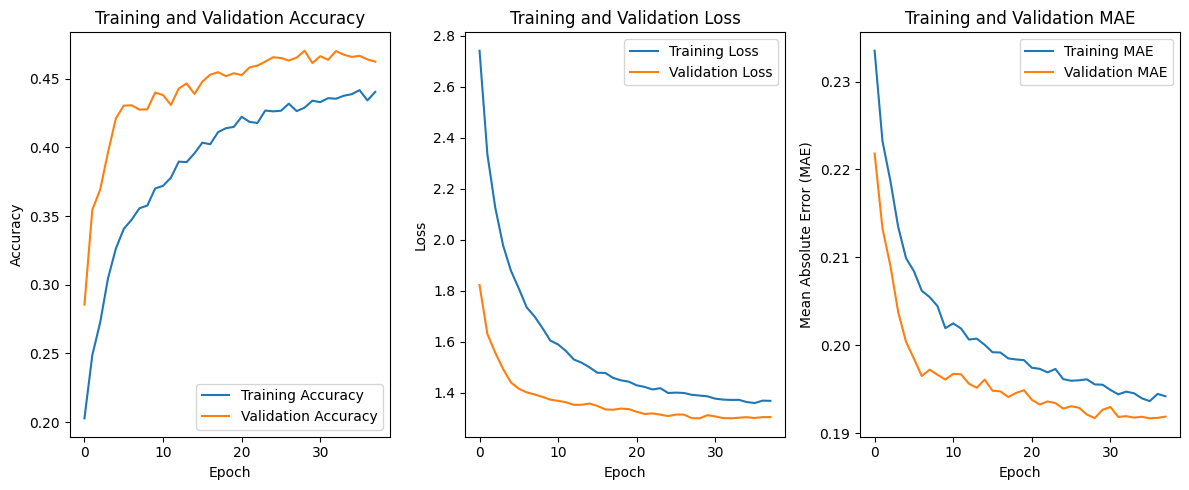

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and have the `history` object

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 3, 3)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels from validation dataset
y_true = []

for (_, _), labels in val_dataset:
    y_true.append(labels.numpy())

# Predict on the entire validation set
y_pred_probs = model.predict(val_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_true to numpy array
y_true = np.concatenate(y_true)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=adult_labels, yticklabels=adult_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
model.save("convnext19000_50epochs.keras")

NameError: name 'history' is not defined

In [ ]:
# To load it back
from tensorflow.keras.models import load_model
model = load_model("my_model.h5")